<h1 style="background-color:#a83299;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 20px 20px;font-family:cursive">Clustering text documents and Giving Recommendation Using K-means</h1>

### Pre-condition to Run ###
1. Ensure the data subfolder has those files:<br>
    a. arxiv-metadata-ext-category.csv<br>
    b. arxiv-metadata-ext-citation.csv<br>
    c. arxiv-metadata-ext-taxonomy.csv<br>
    d. arxiv-metadata-ext-version.csv<br>
    e. arxiv-cs-papers-normalized.csv<br>

    If those files do not exist, please run get_clean_text.py, line 62, the function `load_cs_papers("")` and line 65, `load_cs_papers("", "normalized", run_preprocessor=True)` to get those files ready.

    f. download `arxiv-cs-papers-abstract_spacy_tokens.pickle` to folder `models` if you want to re-load the data files. This pickle file contains only abstract column which removes stop-words and lemmatinzed.<br>
2. If you want to re-train those word2vec, Kmeans models, etc., set variable `FAST_RUN_WITH_EXISTING_DATA` in the first cell to False. You could start to run the cells in sequence (skip the step 3). The whole model building process might take 1 hour.

3. If you want to use the existing trained models and other data, skip step 2, and copy the data from this address: https://drive.google.com/drive/u/1/folders/1X-C6FK1IA-rYDuhZZmkFIQcZ43BpkQuE to your project folder. Ensure those files are put under project_folder/model_data/. Keep `FAST_RUN_WITH_EXISTING_DATA` variable to True, and you could start to run the code in sequence.

In [29]:
# !pip install gensim
# !pip install wordcloud

In [66]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import kmeans_classify
pd.options.display.max_seq_items = 1000


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the pre-existing csv files into dataframes. Please ensure those .csv files exist in subfolder "data". If the .csv file does not exist, you need to run get_clean_text.py, line 62, `cs_papers = load_cs_papers("")` to download and process the abstract text.

In [67]:
# Prepare the dataframes 
df_citations = pd.read_csv("data/arxiv-metadata-ext-citation.csv",dtype={"id":object,"id_reference":object})
print("total records of df:citations:", df_citations.shape)

df_categories = pd.read_csv("data/arxiv-metadata-ext-category.csv",dtype={"id":object,"category_id":object})
print("total records of df:categories:", df_categories.shape)

df_taxonomy = pd.read_csv("data/arxiv-metadata-ext-taxonomy.csv")
print("total records of df_taxonomy:",df_taxonomy.shape)

df_versions = pd.read_csv("data/arxiv-metadata-ext-version.csv", dtype={'id': object})
print("total records of df_versions:",df_versions.shape)

'''
The three parameters will control
a. whether re-train the model or just load model from existing pickle file
b. whether using tf-idf or word2vec to vectorize words and docs
c. whether normalize word2vec result
Note: If using trained models, all the data is in https://drive.google.com/drive/u/1/folders/1SkgvFmTrqfRzHRMJZQcy557MsSpkdnGl, download the folder `model_data` and put it under project path.
'''
FAST_RUN_WITH_EXISTING_DATA = True         # choose fast running or not
NORMALIZE_VECTOR = True                    # choose using normalized vectors or not

total records of df:citations: (6849633, 2)
total records of df:categories: (4173480, 2)
total records of df_taxonomy: (155, 6)
total records of df_versions: (2455227, 3)


Load the .csv file and concatenate with df_categories and df_taxonomy, so that the returned dataframe data_df contains more complete information about the paper. Please note:

a. A new field called "year" is added when you call the following function `kmeans_classify.concatenate_data`. The "year" field represents the published year of the paper. 
b. The abstract fields remove stop words of English in this function.

Exploratory Data Analysis: It is optional to call the function `view_top_category_paper_amount`. It is used to choose the top categories which contains the most amount of published paper. The result is shown in the diagram. The returned value records the list of all those top categories.

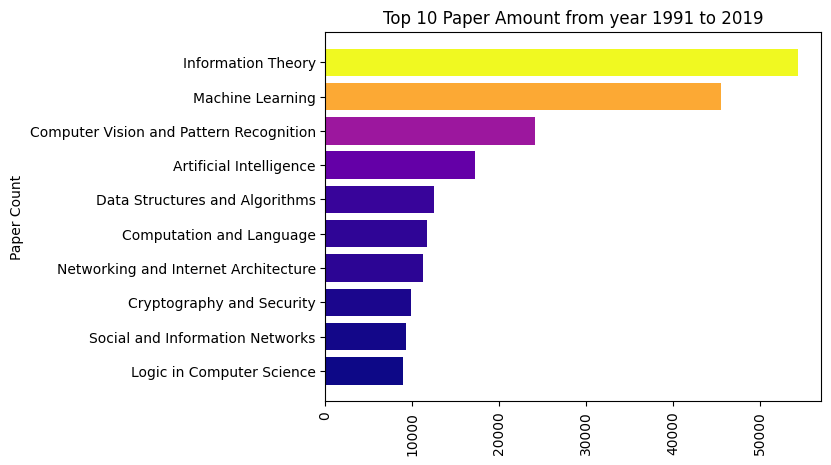

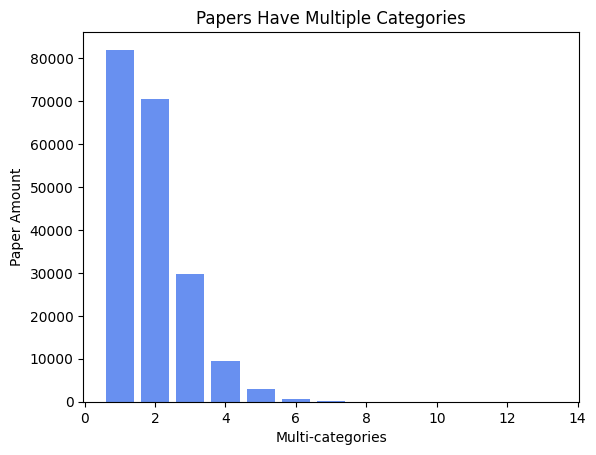

In [68]:

if FAST_RUN_WITH_EXISTING_DATA:
    data_df = pd.read_csv("model_data/data_df.csv", dtype={"id":object})
else:
    # concatenate data_df with df_categories and df_taxonomy to involve more info about the paper
    df_paper =  pd.read_csv("data/arxiv-cs-papers-normalized.csv", dtype={"id":object})
    print("total records of df_paper:",df_paper.shape)
    abstract_df = pd.DataFrame(pd.read_pickle("models/arxiv-cs-papers-abstract_spacy_tokens.pickle"))
    data_df = kmeans_classify.further_process_data(df_paper, abstract_df)

# Show the multi-category issue
concatenate_data = data_df.merge(df_categories, how = "left", on="id")
concatenate_data = concatenate_data.merge(df_taxonomy, how='left', on='category_id')
top_categories = kmeans_classify.view_top_category_paper_amount(concatenate_data, 10)

## Text Document Clustering ##

Cluster documents using K-means algorithm:
1. Convert words into vectors by using word2vec.
2. Convert each doc into a vector by averaging all the word vectors in the doc.
3. Use k-means clustering to perform unsupervised clustering of the documents.
4. Check clustering quality by using metrics such as homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score and silhouette_score

In [27]:

if FAST_RUN_WITH_EXISTING_DATA:


    tfidf_vectorizer = kmeans_classify.load_from_pickle("model_data/tfidf_vectorizer.pkl")
    tfidf_km = kmeans_classify.load_from_pickle("model_data/tfidf_km_model.pkl")

    norm_word_vectorizer = kmeans_classify.load_from_pickle("model_data/norm_word2vec_model.pkl")
    norm_vectorized_docs = kmeans_classify.load_from_pickle("model_data/norm_vectorized_doc.pkl")
    norm_km_model = kmeans_classify.load_from_pickle("model_data/norm_km_model.pkl")

    word_vectorizer = kmeans_classify.load_from_pickle("model_data/word2vec_model.pkl")
    vectorized_docs = kmeans_classify.load_from_pickle("model_data/vectorized_doc.pkl")
    km_model = kmeans_classify.load_from_pickle("model_data/km_model.pkl")
        # kmeans_classify.check_kmean_efficiency(km_model, data_df, vectorized_docs)
else:
    ##### only need to create once / or update those models when necessary. Most of conditions, we only need to load the existing models from pickle files. Once running, the pickle files got updated automatically with the new model data.
    # train both raw word2vec and normalized word2vec and tfidf vectorizer. Save to different pickle files
    word_vectorizer, vectorized_docs = kmeans_classify.generate_word_and_doc_vectors(data_df)
    km_model = kmeans_classify.fit_kmean_model(25, vectorized_docs)

    # generated normalized word and doc vectors
    norm_word_vectorizer, norm_vectorized_docs = kmeans_classify.normalize_word2vec_model(data_df, word_vectorizer)
    norm_km_model = kmeans_classify.fit_kmean_model(25, norm_vectorized_docs, normalize = True)   
    
    tfidf_vectorizer, tfidf_doc_vectors, tfidf_tokens  = kmeans_classify.generate_tfidf_vectors(data_df)
    tfidf_km_model = kmeans_classify.fit_kmean_model_tfidf(25, tfidf_doc_vectors) 


Generating word vectors... Take 30+ mins.
Starting vectorizing docs 0-5000
Starting vectorizing docs 5000-10000
Starting vectorizing docs 10000-15000
Starting vectorizing docs 15000-20000
Starting vectorizing docs 20000-25000
Starting vectorizing docs 25000-30000
Starting vectorizing docs 30000-35000
Starting vectorizing docs 35000-40000
Starting vectorizing docs 40000-45000
Starting vectorizing docs 45000-50000
Starting vectorizing docs 50000-55000
Starting vectorizing docs 55000-60000
Starting vectorizing docs 60000-65000
Starting vectorizing docs 65000-70000
Starting vectorizing docs 70000-75000
Starting vectorizing docs 75000-80000
Starting vectorizing docs 80000-85000
Starting vectorizing docs 85000-90000
Starting vectorizing docs 90000-95000
Starting vectorizing docs 95000-100000
Starting vectorizing docs 100000-105000
Starting vectorizing docs 105000-110000
Starting vectorizing docs 110000-115000
Starting vectorizing docs 115000-120000
Starting vectorizing docs 120000-125000
Sta

c:\Users\Claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Starting vectorizing docs 0-5000
Starting vectorizing docs 5000-10000
Starting vectorizing docs 10000-15000
Starting vectorizing docs 15000-20000
Starting vectorizing docs 20000-25000
Starting vectorizing docs 25000-30000
Starting vectorizing docs 30000-35000
Starting vectorizing docs 35000-40000
Starting vectorizing docs 40000-45000
Starting vectorizing docs 45000-50000
Starting vectorizing docs 50000-55000
Starting vectorizing docs 55000-60000
Starting vectorizing docs 60000-65000
Starting vectorizing docs 65000-70000
Starting vectorizing docs 70000-75000
Starting vectorizing docs 75000-80000
Starting vectorizing docs 80000-85000
Starting vectorizing docs 85000-90000
Starting vectorizing docs 90000-95000
Starting vectorizing docs 95000-100000
Starting vectorizing docs 100000-105000
Starting vectorizing docs 105000-110000
Starting vectorizing docs 110000-115000
Starting vectorizing docs 115000-120000
Starting vectorizing docs 120000-125000
Starting vectorizing docs 125000-130000
Start

### Recommend papers by responding to user query

There are two choices to recommend papers.
First choice: choose by comparing keywords of each doc with user input. However, this method is more accurate but time-consuming. It does not use the pre-training result of KMeans.

Second choice: choose by comparing the user query's doc distance to the cluster_centers. This project will use this method. Kmean model's predict method accepts the user query's doc ventor as input, and predict the closest cluster the doc belongs to.

### 1. Use Word2Vec in KMeans Model ###


Cluster 21's top 10 most cited papers:
           id                                              title
0   1212.5701         ADADELTA: An Adaptive Learning Rate Method
1   1301.3781  Efficient Estimation of Word Representations i...
2   1312.5602     Playing Atari with Deep Reinforcement Learning
3   1312.6199           Intriguing properties of neural networks
4   1406.1078  Learning Phrase Representations using RNN Enco...
5   1411.1784            Conditional Generative Adversarial Nets
6   1412.3555  Empirical Evaluation of Gated Recurrent Neural...
7   1412.6572     Explaining and Harnessing Adversarial Examples
8  1502.03167  Batch Normalization: Accelerating Deep Network...
9  1503.02531       Distilling the Knowledge in a Neural Network


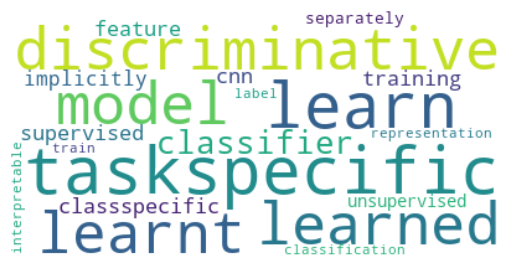


Cluster 22's top 10 most cited papers:
           id                                              title
0   1408.5093  Caffe: Convolutional Architecture for Fast Fea...
1  1603.04467  TensorFlow: Large-Scale Machine Learning on He...
2  1606.01540                                         OpenAI Gym
3  1606.06565                     Concrete Problems in AI Safety
4  1612.03801                                       DeepMind Lab
5  1612.08083  Language Modeling with Gated Convolutional Net...
6  1705.04304  A Deep Reinforced Model for Abstractive Summar...
7  1705.06950            The Kinetics Human Action Video Dataset
8  1707.06347            Proximal Policy Optimization Algorithms
9  cs/0004015  Introduction to the GiNaC Framework for Symbol...


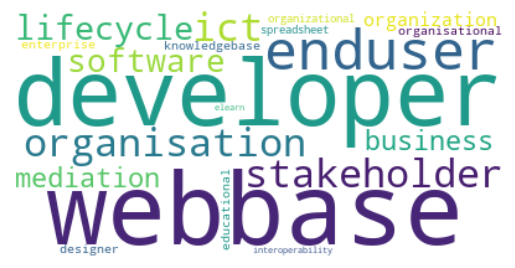


Cluster 23's top 10 most cited papers:
           id                                              title
0   1009.5055  The Augmented Lagrange Multiplier Method for E...
1   1308.3432  Estimating or Propagating Gradients Through St...
2   1309.2388  Minimizing Finite Sums with the Stochastic Ave...
3   1312.6114                    Auto-Encoding Variational Bayes
4   1412.6980         Adam: A Method for Stochastic Optimization
5  1505.05424              Weight Uncertainty in Neural Networks
6  1505.05770       Variational Inference with Normalizing Flows
7  1506.08473  Beating the Perils of Non-Convexity: Guarantee...
8  1609.04836  On Large-Batch Training for Deep Learning: Gen...
9  1802.00420  Obfuscated Gradients Give a False Sense of Sec...


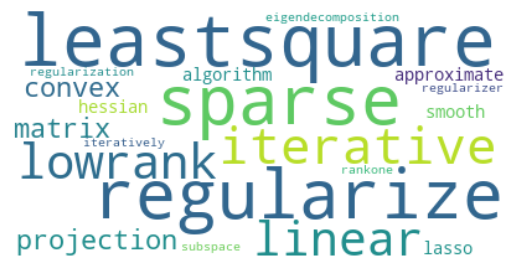


Cluster 24's top 10 most cited papers:
           id                                              title
0  1502.05698  Towards AI-Complete Question Answering: A Set ...
1  1506.02078   Visualizing and Understanding Recurrent Networks
2  1511.05952                      Prioritized Experience Replay
3  1512.02595  Deep Speech 2: End-to-End Speech Recognition i...
4  1512.03012  ShapeNet: An Information-Rich 3D Model Repository
5  1704.04861  MobileNets: Efficient Convolutional Neural Net...
6  1705.03122        Convolutional Sequence to Sequence Learning
7  1707.01083  ShuffleNet: An Extremely Efficient Convolution...
8  1709.01507                    Squeeze-and-Excitation Networks
9  1710.10196  Progressive Growing of GANs for Improved Quali...


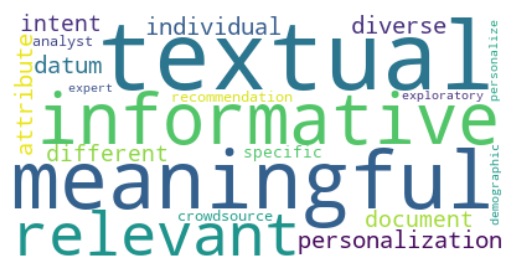

In [41]:
# If you want to know each cluster's keywords, top cited papers, generate word cloud for top keywords, call this method
# USE_TFIDF = False

if NORMALIZE_VECTOR is True:
    for i in range(21, 25):
        print("Use normalized word2vec:")
        kmeans_classify.report_cluster_info(i, norm_word_vectorizer, norm_km_model, data_df, df_citations, norm_vectorized_docs)
else:
    for i in range(21, 25):
        print("Use raw word2vec:")
        kmeans_classify.report_cluster_info(i, word_vectorizer, km_model, data_df, df_citations, vectorized_docs)
    

this input is closest to this cluster 23

Cluster 23's top 10 most cited papers:
           id                                              title
0   1009.5055  The Augmented Lagrange Multiplier Method for E...
1   1308.3432  Estimating or Propagating Gradients Through St...
2   1309.2388  Minimizing Finite Sums with the Stochastic Ave...
3   1312.6114                    Auto-Encoding Variational Bayes
4   1412.6980         Adam: A Method for Stochastic Optimization
5  1505.05424              Weight Uncertainty in Neural Networks
6  1505.05770       Variational Inference with Normalizing Flows
7  1506.08473  Beating the Perils of Non-Convexity: Guarantee...
8  1609.04836  On Large-Batch Training for Deep Learning: Gen...
9  1802.00420  Obfuscated Gradients Give a False Sense of Sec...


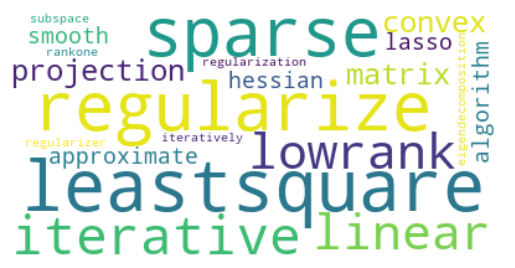

In [43]:

# get user input vector
if NORMALIZE_VECTOR is True:
    user_input = "loss function deep learning algorithm optimization"
    kmeans_classify.predict_user_query_cluster(user_input, norm_word_vectorizer, norm_km_model, data_df, df_citations, norm_vectorized_docs)
else:
    user_input = "loss function deep learning algorithm optimization"
    kmeans_classify.predict_user_query_cluster(user_input, word_vectorizer, km_model, data_df, df_citations, vectorized_docs)



### 2. Use Tf-idf in KMeans Model ###


Cluster 0's top 10 most cited papers:
           id                                              title
0  1502.01815  Fog Computing: Focusing on Mobile Users at the...
1  1702.03920  Cognitive Mapping and Planning for Visual Navi...
2  1702.07432  Multi-Context Attention for Human Pose Estimation
3  1704.03732                Deep Q-learning from Demonstrations
4  1706.02677  Accurate, Large Minibatch SGD: Training ImageN...
5  1706.03175  Recovery Guarantees for One-hidden-layer Neura...
6  1709.10089  Overcoming Exploration in Reinforcement Learni...
7  1710.06081         Boosting Adversarial Attacks with Momentum
8  1711.02838  Stochastic Cubic Regularization for Fast Nonco...
9  1804.04168  Differentiable Learning of Quantum Circuit Bor...
Cluster 0's top 20 keywords: ['service', 'cloud', 'computing', 'resource', 'cloud computing', 'provider', 'datum', 'application', 'system', 'user', 'network', 'web', 'mobile', 'infrastructure', 'web service', 'use', 'technology', 'provide', 'secu

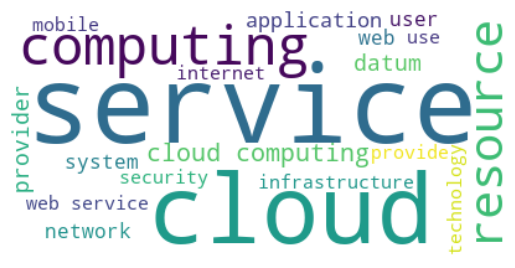


Cluster 1's top 10 most cited papers:
                 id                                              title
0         0907.2557                  The Multiple Zeta Value Data Mine
1         1012.2599  A Tutorial on Bayesian Optimization of Expensi...
2         1105.6063  Harmonic Sums and Polylogarithms Generated by ...
3         1106.1445           From Classical to Quantum Shannon Theory
4         1203.6543                                   FORM version 4.0
5        1505.05770       Variational Inference with Normalizing Flows
6        1611.01144  Categorical Reparameterization with Gumbel-Sof...
7        1703.05192  Learning to Discover Cross-Domain Relations wi...
8  quant-ph/0402130       A categorical semantics of quantum protocols
9  quant-ph/9802049                Quantum Lower Bounds by Polynomials
Cluster 1's top 20 keywords: ['function', 'problem', 'set', 'number', 'bound', 'result', 'quantum', 'prove', 'theory', 'complexity', 'use', 'bind', 'polynomial', 'distribution', 'p

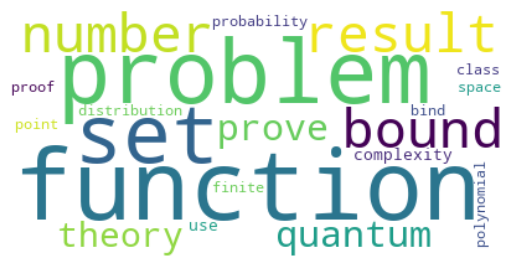


Cluster 2's top 10 most cited papers:
           id                                              title
0   1211.5063  On the difficulty of training Recurrent Neural...
1   1212.5701         ADADELTA: An Adaptive Learning Rate Method
2   1308.3432  Estimating or Propagating Gradients Through St...
3   1309.2388  Minimizing Finite Sums with the Stochastic Ave...
4   1412.6980         Adam: A Method for Stochastic Optimization
5  1506.08473  Beating the Perils of Non-Convexity: Guarantee...
6  1606.04838  Optimization Methods for Large-Scale Machine L...
7  1609.04747  An overview of gradient descent optimization a...
8  1609.04836  On Large-Batch Training for Deep Learning: Gen...
9  1611.00712  The Concrete Distribution: A Continuous Relaxa...
Cluster 2's top 20 keywords: ['gradient', 'descent', 'stochastic', 'gradient descent', 'stochastic gradient', 'method', 'convergence', 'algorithm', 'optimization', 'function', 'convex', 'rate', 'learning', 'problem', 'nonconvex', 'convergence rat

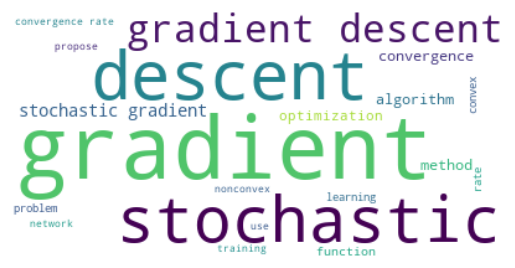


Cluster 3's top 10 most cited papers:
           id                                              title
0   1209.5145  Julia: A Fast Dynamic Language for Technical C...
1   1309.4168  Exploiting Similarities among Languages for Ma...
2   1312.3005  One Billion Word Benchmark for Measuring Progr...
3   1409.0473  Neural Machine Translation by Jointly Learning...
4  1506.07285  Ask Me Anything: Dynamic Memory Networks for N...
5  1508.04025  Effective Approaches to Attention-based Neural...
6  1508.06615             Character-Aware Neural Language Models
7  1602.02410          Exploring the Limits of Language Modeling
8  1611.04558  Google's Multilingual Neural Machine Translati...
9  cs/0004015  Introduction to the GiNaC Framework for Symbol...
Cluster 3's top 20 keywords: ['language', 'translation', 'natural language', 'natural', 'model', 'semantic', 'programming', 'use', 'system', 'machine translation', 'programming language', 'machine', 'text', 'sentence', 'program', 'word', 'paper',

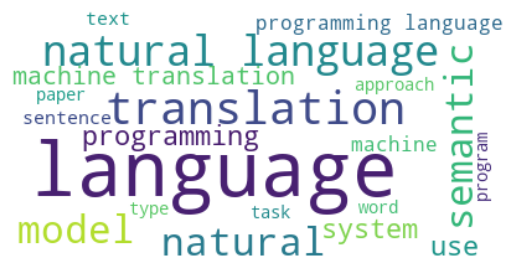


Cluster 4's top 10 most cited papers:
                 id                                              title
0         0906.1030  Unconditional security from noisy quantum storage
1         1409.3525  Cryptographic security of quantum key distribu...
2        1602.02672  Learning to Communicate to Solve Riddles with ...
3        1607.01797  Simple and tight device-independent security p...
4        1612.07182  Multi-Agent Cooperation and the Emergence of (...
5  quant-ph/0108010  Classical simulation of noninteracting-fermion...
6  quant-ph/0205133  Adaptive Quantum Computation, Constant Depth Q...
7  quant-ph/0402095  Limitations of Quantum Advice and One-Way Comm...
8  quant-ph/0403120   Quantum walks and their algorithmic applications
9  quant-ph/0605181  The BQP-hardness of approximating the Jones Po...
Cluster 4's top 20 keywords: ['protocol', 'quantum', 'security', 'network', 'communication', 'key', 'secure', 'attack', 'use', 'routing', 'route', 'node', 'propose', 'message', 'wi

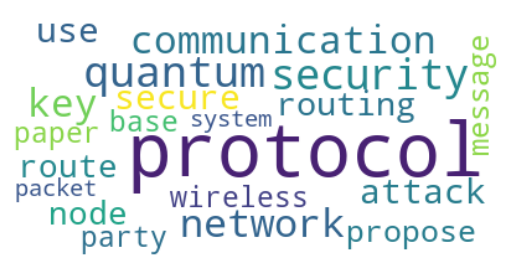

In [55]:

# randomly choose some clusters to check the keywords and top cited papers in the clusters
for i in range(0, 5):
    kmeans_classify.report_cluster_info_tfidf(i, tfidf_vectorizer, tfidf_km_model, data_df, df_citations)

this input is closest to this cluster 2

Cluster 2's top 10 most cited papers:
           id                                              title
0   1211.5063  On the difficulty of training Recurrent Neural...
1   1212.5701         ADADELTA: An Adaptive Learning Rate Method
2   1308.3432  Estimating or Propagating Gradients Through St...
3   1309.2388  Minimizing Finite Sums with the Stochastic Ave...
4   1412.6980         Adam: A Method for Stochastic Optimization
5  1506.08473  Beating the Perils of Non-Convexity: Guarantee...
6  1606.04838  Optimization Methods for Large-Scale Machine L...
7  1609.04747  An overview of gradient descent optimization a...
8  1609.04836  On Large-Batch Training for Deep Learning: Gen...
9  1611.00712  The Concrete Distribution: A Continuous Relaxa...
Cluster 2's top 20 keywords: ['gradient', 'descent', 'stochastic', 'gradient descent', 'stochastic gradient', 'method', 'convergence', 'algorithm', 'optimization', 'function', 'convex', 'rate', 'learning', 

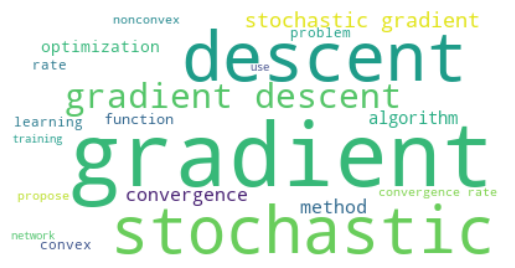

In [54]:

# get user input vector
user_input = "gradient descent loss function optimization method comparison"
kmeans_classify.predict_user_query_cluster_tfidf(user_input, tfidf_vectorizer, tfidf_km_model, data_df, df_citations)


# K Hyperparameter Tuning and Prepare Evaluation #
This part is used to tune hyperparameter K of KMeans and compare the performance of different word vectors. No need to run this part of code if you just want to check the output of the KMeans classification method.

* Option Matrix:<b>

1. Three Configurations for word vectorizers: word2vec, word2vec normalized, tfidf<b>
2. Six configurations for K of KMeans: 10, 20, 30, 40, 50 ,60<b>

Generate each model by using the above options and save them to the folder "evaluation" under this project path. You could use `kmeans_clustering_evaluation.jpynb` to evaluate results.

In [62]:
from sklearn.cluster import KMeans
import os 

evaluation_folder = os.getcwd() + "/evaluation"
if not os.path.exists(evaluation_folder):
    os.makedirs(evaluation_folder)

word_vectorizer = kmeans_classify.load_from_pickle("model_data/word2vec_model.pkl")
vectorized_docs = kmeans_classify.load_from_pickle("model_data/vectorized_doc.pkl")

norm_word_vectorizer = kmeans_classify.load_from_pickle("model_data/norm_word2vec_model.pkl")
norm_vectorized_docs = kmeans_classify.load_from_pickle("model_data/norm_vectorized_doc.pkl")
tfidf_vectorizer = kmeans_classify.load_from_pickle("model_data/tfidf_vectorizer.pkl")
tfidf_vectorized_docs = kmeans_classify.load_from_pickle("model_data/tfidf_vectorized_doc.pkl")

for k in [10, 20, 30, 40, 50, 60]:
    evaluation_df = data_df[['id']]
    km_eval_model = KMeans(n_clusters= k, init='k-means++', max_iter=200, n_init="auto")
    km_eval_model.fit(vectorized_docs)
    print("Start fit into Kmeans word2vec model. Make take several minutes.")

    evaluation_df['topic_id'] = km_eval_model.labels_.tolist()
    evaluation_df.to_csv(evaluation_folder + "/kmeans_word2vec_" + str(k) + ".csv", index = False)

    evaluation_df = data_df[['id']]
    norm_km_eval_model = KMeans(n_clusters= k, init='k-means++', max_iter=200, n_init="auto")
    norm_km_eval_model.fit(norm_vectorized_docs)
    print("Start fit into Kmeans word2vec normalized model. Make take several minutes.")

    evaluation_df['topic_id'] = norm_km_eval_model.labels_.tolist()
    evaluation_df.to_csv(evaluation_folder + "/kmeans_norm_word2vec_" + str(k) + ".csv", index = False)

for k in [10, 20, 30, 40, 50, 60]:
    evaluation_df = data_df[['id']]
    km_eval_tfidf_model = KMeans(n_clusters=k, init='k-means++', max_iter=200, n_init="auto")
    print("Start fit into Kmeans tfidf model. Make take several minutes.")
    km_eval_tfidf_model.fit(tfidf_vectorized_docs)

    evaluation_df['topic_id'] = km_eval_tfidf_model.labels_.tolist()
    evaluation_df.to_csv(evaluation_folder + "/kmeans_tfidf_" + str(k) + ".csv", index = False)


Start fit into Kmeans word2vec model. Make take several minutes.


C:\Users\Claud\AppData\Local\Temp\ipykernel_5344\3939347890.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df['topic_id'] = km_eval_model.labels_.tolist()


Start fit into Kmeans word2vec normalized model. Make take several minutes.


C:\Users\Claud\AppData\Local\Temp\ipykernel_5344\3939347890.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df['topic_id'] = norm_km_eval_model.labels_.tolist()


Start fit into Kmeans word2vec model. Make take several minutes.


C:\Users\Claud\AppData\Local\Temp\ipykernel_5344\3939347890.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df['topic_id'] = km_eval_model.labels_.tolist()


Start fit into Kmeans word2vec normalized model. Make take several minutes.


C:\Users\Claud\AppData\Local\Temp\ipykernel_5344\3939347890.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df['topic_id'] = norm_km_eval_model.labels_.tolist()


Start fit into Kmeans word2vec model. Make take several minutes.


C:\Users\Claud\AppData\Local\Temp\ipykernel_5344\3939347890.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df['topic_id'] = km_eval_model.labels_.tolist()


Start fit into Kmeans word2vec normalized model. Make take several minutes.


C:\Users\Claud\AppData\Local\Temp\ipykernel_5344\3939347890.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df['topic_id'] = norm_km_eval_model.labels_.tolist()


Start fit into Kmeans word2vec model. Make take several minutes.


C:\Users\Claud\AppData\Local\Temp\ipykernel_5344\3939347890.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df['topic_id'] = km_eval_model.labels_.tolist()


Start fit into Kmeans word2vec normalized model. Make take several minutes.


C:\Users\Claud\AppData\Local\Temp\ipykernel_5344\3939347890.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df['topic_id'] = norm_km_eval_model.labels_.tolist()


Start fit into Kmeans word2vec model. Make take several minutes.


C:\Users\Claud\AppData\Local\Temp\ipykernel_5344\3939347890.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df['topic_id'] = km_eval_model.labels_.tolist()


Start fit into Kmeans word2vec normalized model. Make take several minutes.


C:\Users\Claud\AppData\Local\Temp\ipykernel_5344\3939347890.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df['topic_id'] = norm_km_eval_model.labels_.tolist()


Start fit into Kmeans word2vec model. Make take several minutes.


C:\Users\Claud\AppData\Local\Temp\ipykernel_5344\3939347890.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df['topic_id'] = km_eval_model.labels_.tolist()


Start fit into Kmeans word2vec normalized model. Make take several minutes.


C:\Users\Claud\AppData\Local\Temp\ipykernel_5344\3939347890.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df['topic_id'] = norm_km_eval_model.labels_.tolist()


Start fit into Kmeans tfidf model. Make take several minutes.


C:\Users\Claud\AppData\Local\Temp\ipykernel_5344\3939347890.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df['topic_id'] = km_eval_tfidf_model.labels_.tolist()


Start fit into Kmeans tfidf model. Make take several minutes.


C:\Users\Claud\AppData\Local\Temp\ipykernel_5344\3939347890.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df['topic_id'] = km_eval_tfidf_model.labels_.tolist()


Start fit into Kmeans tfidf model. Make take several minutes.


C:\Users\Claud\AppData\Local\Temp\ipykernel_5344\3939347890.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df['topic_id'] = km_eval_tfidf_model.labels_.tolist()


Start fit into Kmeans tfidf model. Make take several minutes.


C:\Users\Claud\AppData\Local\Temp\ipykernel_5344\3939347890.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df['topic_id'] = km_eval_tfidf_model.labels_.tolist()


Start fit into Kmeans tfidf model. Make take several minutes.


C:\Users\Claud\AppData\Local\Temp\ipykernel_5344\3939347890.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df['topic_id'] = km_eval_tfidf_model.labels_.tolist()


Start fit into Kmeans tfidf model. Make take several minutes.


C:\Users\Claud\AppData\Local\Temp\ipykernel_5344\3939347890.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df['topic_id'] = km_eval_tfidf_model.labels_.tolist()
